In [39]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import myst_nb

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'plotly_mimetype+svg'
pio.templates['book'] = go.layout.Template(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        width=350, height=250,
    )
)
pio.templates.default = 'seaborn+book'

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [40]:
sfh_all = pd.read_csv('data/sfhousing.csv', error_bad_lines=False)
sfh = sfh_all.query('year == 2004')
dogs = pd.read_csv('data/akc.csv').dropna()

b'Skipping line 30550: expected 11 fields, saw 12\n'
b'Skipping line 343819: expected 11 fields, saw 12\n'


In [41]:
should_clear = ['bingroup']

def clear_prop(trace, prop):
    if hasattr(trace, prop):
        trace.update({prop: None})
        
def clear_props(traces):
    for trace in traces:
        for prop in should_clear:
            clear_prop(trace, prop)

def left_right(left, right, width=700, height=250, **kwargs):
    fig = make_subplots(cols=2, **kwargs)
    fig.update_layout(width=width, height=height)
    
    t1 = next(left.select_traces())
    t2 = next(right.select_traces())
    clear_props([t1, t2])
    fig.add_trace(t1, row=1, col=1)
    fig.add_trace(t2, row=1, col=2)
    return fig

def margin(fig, **kwargs):
    return fig.update_layout(margin=kwargs)

(ch:viz_scale)=
# Choosing Scale to Reveal Structure


In {numref}`Section %s <ch:eda_example>` we first explored housing prices for house sold in the San Francisico Bay Area between 2003 and 2009. Let's revisit that example and take a look at the following histogram of house prices.

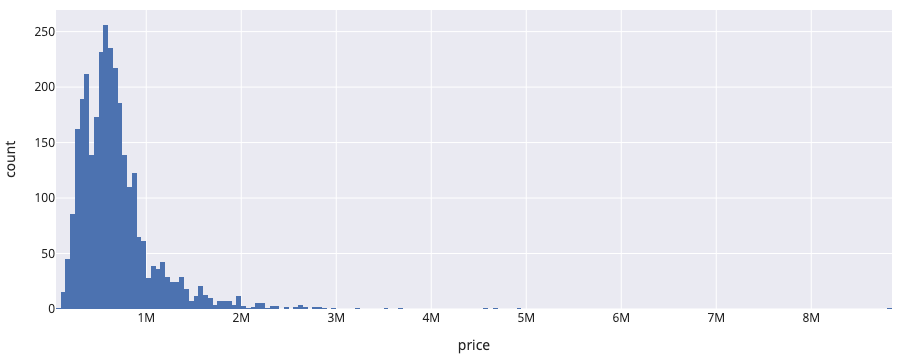

In [42]:
px.histogram(sfh, x='price', width=350, height=250)

Is this plot accurate? Yes---it displays all the data.
But most of the data are crammed into the left side of the plot, which makes it
hard to use the plot to understand house prices.

Through data visualization, we want to reveal important features of the data
like the shape of a distribution and the relationship between features. 
As this example shows, after we produce an initial plot there are still
other principles we need to consider.
In this section, we cover *principles of scale* which help us decide how to
adjust the axis limits, place tick marks, and apply transformations. 
We begin by examining when and how we might adjust a plot to reduce empty space; in other words we try to fill the data region of our plot.

## Filling the Data Region

As we can see from the above plot of house prices, it's hard to read
a distribution when
most of the data appear in a small portion of the plotting region.
When this happens, we can't clearly see important features about the data like
whether there are multiple modes or skewness.
A similar issue happens for scatter plots. 
When all the points are bunched together in a scatter plot, it's hard to
see nonlinearity.

This issue can happen when there are a few unusually large observations.
In order to get a better view of the main portion
of the data we can drop these observations from the plot by adjusting the
x- or y-axis limits, or by removing outlier values from the data before
plotting.
In either case, we must mention this exclusion in
the caption or on the plot itself.

Let's improve the above plot of housing prices. In the plot below, we've put the
default histogram on the left. In the side-by-side plots below, we clip the data by changing the 
limits of the x-axis. On the left, we've excluded houses that cost
over \$2,000,000. 
The shape of the distribution for the bulk of the houses is much clearer in 
this plot.
For instance, we can more easily observe the skewness of the main mode and possible bimodality.
On the right, we show the detail in the long right tail of this distribution with
a separate plot.

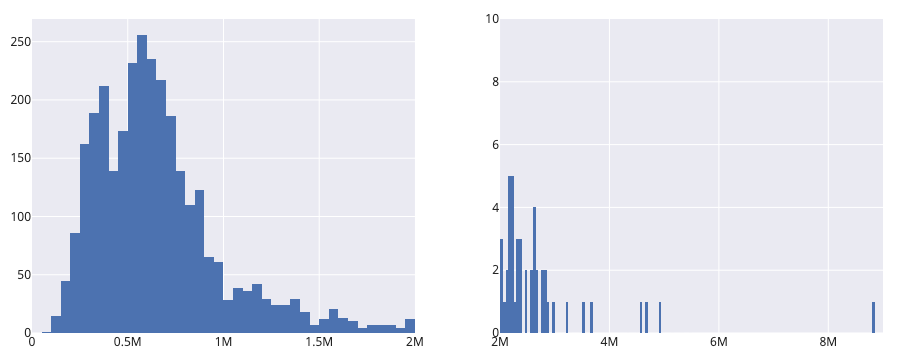

In [43]:
right = px.histogram(sfh, x='price')
left = px.histogram(sfh, x='price')

fig = left_right(right, left, height=300)
fig.update_xaxes(range=[0, 2e6], row=1, col=1)
fig.update_xaxes(range=[2e6, 9e6], row=1, col=2)
fig.update_yaxes(range=[0, 10], row=1, col=2)
fig
#fig.update_xaxes(range=[0, 2e6], row=1, col=2)

We addressed the issue of scale in the original histogram of housing prices by making two plots, one for the bulk of the data and one for the tail. By choosing useful x- and y-axis limits for both plots, we can show additional
useful information about the distribution. 

Notice that the x-axis in the right plot includes 0, but the left plot begins its x-axis at \$2,000,000. We consider when to include or exclude 0 on an axis next. 

## Including Zero

We often don't need to include 0 on an axis, especially if including it makes it difficult to fill the data region. For instance, the scatter plot below shows the average longevity plotted
against average height for dog breeds. (This dataset is provided by the American Kennel Club (AKC) and was first introduced in {numref}'Chapter %s <ch:eda>'; it include several features for 172 breeds.)
The x-axis of the plot starts at 10 cm since
all dogs are taller than that, and, similarly, the y-axis begins at 5 years.

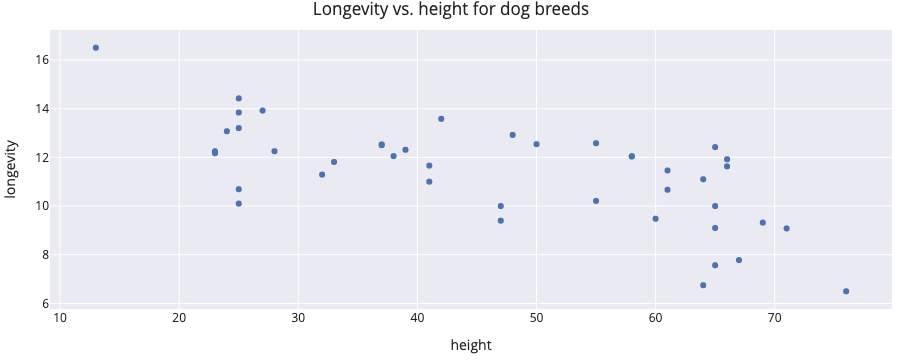

In [44]:
fig = px.scatter(dogs, x='height', y='longevity',
                 title='Longevity vs. height for dog breeds',
                 width=350, height=250)
margin(fig, t=30)

There are a few cases where we usually want to include 0.
For bar charts, including 0 is important so the heights of the bars directly relate to the data.
As an example, we've created two bar charts that compare the longevity of dog breeds below. 
The left plot includes 0, but the right plot doesn't. It's easy to incorrectly conclude from the right
plot that medium-sized dogs live twice as long as large-sized dogs.

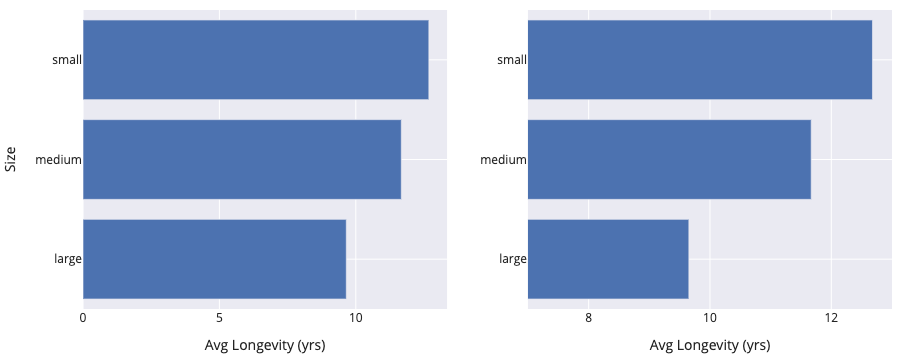

In [45]:
dogs_lon = dogs.groupby('size')['longevity'].mean().reset_index()
sml = {"size": ['small', 'medium', 'large']}
left = px.bar(dogs_lon, x='longevity', y='size', category_orders=sml)
right = px.bar(dogs_lon, x='longevity', y='size', category_orders=sml)

fig = left_right(left, right, height=250)
fig.update_xaxes(range=[7, 13], row=1, col=2)
fig.update_xaxes(title_text='Avg Longevity (yrs)')
fig.update_layout(yaxis_title="Size")

We also typically want to include zero when working with proportions, since
proportions range from 0 to 1.
The plot below shows the proportion of dogs of each dog group in our dataset.

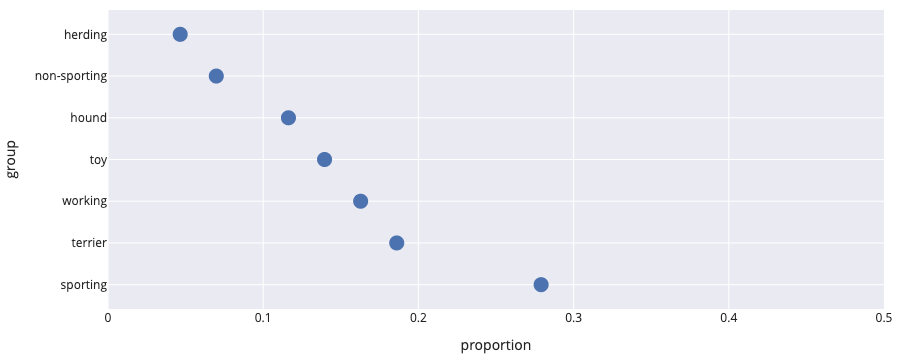

In [46]:
size_props = ((dogs['group'].value_counts() / len(dogs))
              .reset_index()
              .rename(columns={'index': 'group', 'group': 'proportion'}))

size_props
fig = px.scatter(size_props, x='proportion', y='group', category_orders=sml,
                 width=350, height=250)
fig.update_traces(marker_size=15)
fig.update_xaxes(range=[0, 0.5])

In both of these plots, by including 0, you are making it easier for your reader to accurately compare the relative size of groups.  

Earlier, when we adjusted axes, we essentially dropped data from our plotting region. While this is a useful strategy when a handful of observations are unusually large (or small), it is less effective with skewed data. In this situation, we often need to transform the data to gain a better view of the shape of the distribution.  

## Revealing Shape Through Transformations

Another common way to adjust scale is to transform the data or the plot axes. 
We use transformations for skewed data so that it is easier to inspect the distribution.
And, when the transformation produces a symmetric distribution, the symmetry carries with it 
useful properties in later modeling steps.

There are multiple ways to transform data, but the log-transform is especially useful.
For instance, we've reproduced two histograms of SF house prices below.
The left histogram is the original data.
On the right, we've taken the log (base 10) of the pricesbefore plotting.

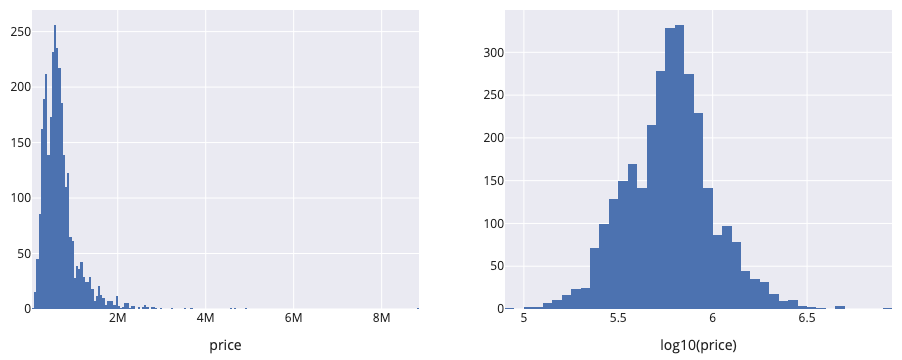

In [47]:
sfl = sfh.assign(log_price=np.log10(sfh['price']))

orig = px.histogram(sfl, x='price', width=350, height=250)
logged = px.histogram(sfl, x='log_price',
                      nbins=100,
                      labels=dict(log_price='log10(price)'),
                      width=350, height=250)

fig = left_right(orig, logged)
fig.update_xaxes(title_text='price', row=1, col=1)
fig.update_xaxes(title_text='log10(price)', row=1, col=2)

The log transformation makes the distribution of prices more symmetric.
Now, we can more easily see important features of the distribution, like
the mode at around $10^{5.85} ≈ \$700,000$ and the secondary mode
near $10^{5.55} ≈ \$350,000$.

The downside of using the log transform is that the actual values aren't
as intuitive---in this example, we needed to convert the values back to
original dollars. Because of this, we often favor transforming the axis to
use a log scale. When we do this, we don't transform the data. Instead,
we set the axis scale when we plot the code.

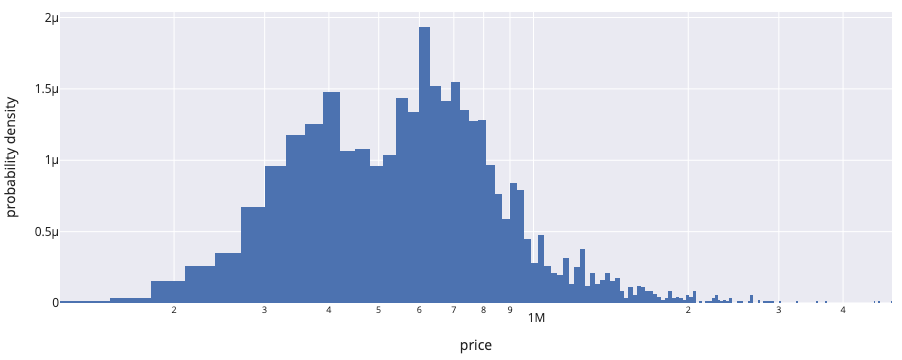

In [48]:
fig = px.histogram(sfh, x='price',
                   log_x=True,
                   histnorm='probability density',
                   width=350, height=250)
fig.update_traces(xbins_size=30_000)

The above histogram with log scaled x-axis shows a similar result to 
directly transforming the data.
But since the axis is displayed using original units, we can directly
read off its values.

The log transform can also reveal shape in scatter plots.
Below, we've put the building size on the x-axis and
the lot size on the y-axis.
It's hard to see the shape in this plot since many of the points are crammed
into the bottom corner of the data region.

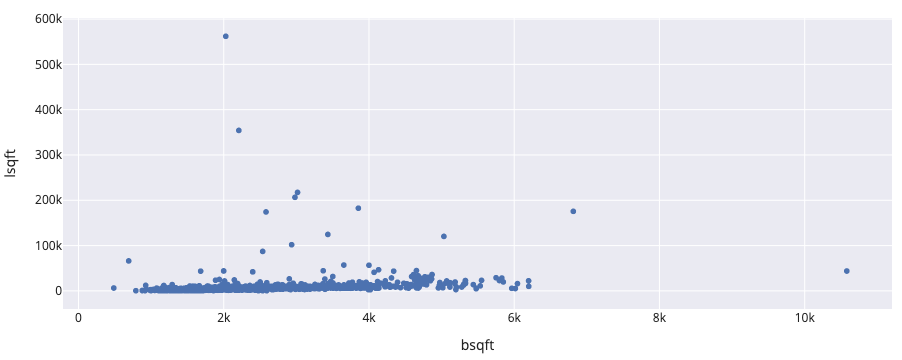

In [49]:
px.scatter(sfh, x='bsqft', y='lsqft',
           width=350, height=250)

However, if we use a log scale for both x- and y-axes, the shape is much
easier to see.

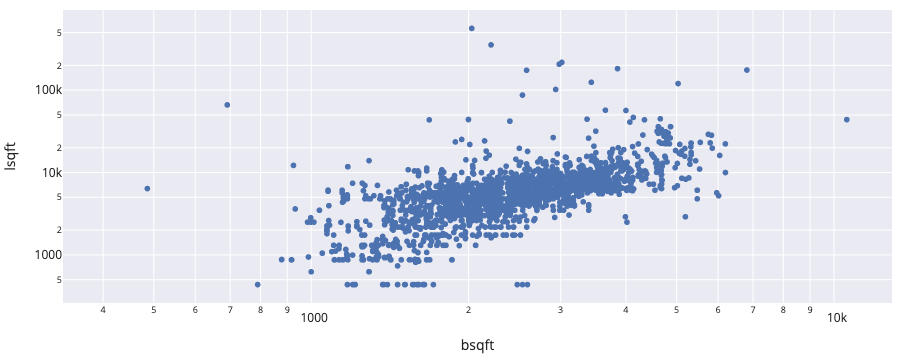

In [50]:
px.scatter(sfh, x='bsqft', y='lsqft',
           log_x=True, log_y=True,
           width=350, height=250)

With the transformed axes, we can see that the lot size increases roughly linearly with building size (on the log scale).

The log transformation pulls large values--values that are orders of magnitude larger than others--in. This transformation can help fill the data region and uncover hidden structure as we saw for both the distribution of house price and the relationship between house size and lot size. 

In addition to settng the limits of an axis and transforming an axis, we also want to consider the aspect ratio of the plot. That is, we want to adjust the shape of the rectangular plot, the plot width and height. We can stretch or shrink a plot without changing its axes limits. This adjustment is called "banking". In the next section, we explain how banking can help reveal relationships between features.  

## Banking to Decipher Relationships

With scatterplots, we try to choose a scale so that the relationship between the two features roughly follows a
45-degree line. This is called "banking to 45 degrees." Banking to 45 degrees makes it
easier for the reader to see shape and trends because our eyes can more easily pick up deviation this way.
That is, it is much easier for us to see departures from a line when the data roughly fall along a 45-degree
line within the plotting region.
For instance, we've reproduced the plot that shows longevity of dog breeds against height.
The plot has been banked to 45 degrees, and we can more easily
see how the data roughly follow a line and where they deviate.

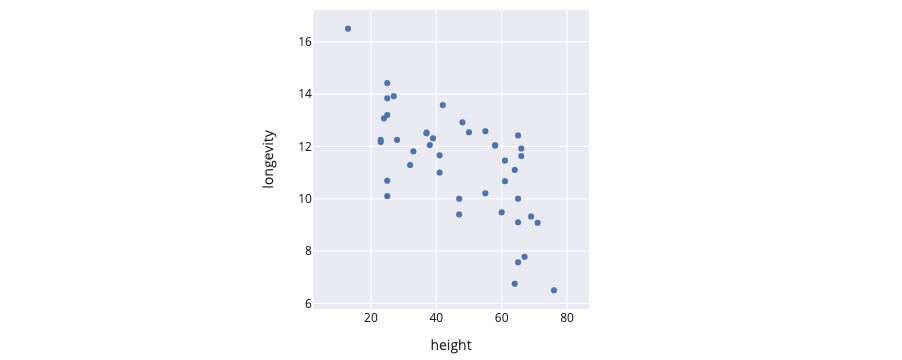

In [51]:
fig = px.scatter(dogs, x='height', y='longevity', width=250, height=250)

fig.update_xaxes(
    constrain="domain",
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=8,
)
fig

While banking to 45 degrees helps us see whether or not the data follow a linear relationship, when there is clear curvature we often find it hard to figure out what nonlinear relationship the data are showing us. When this happens, we try transforming features to linearize our scatter plot. We saw earlier that when we are examininghighly skewed data, the log transformation is often preferrable to simply changing the scale of the x-axis. The log transformation can also be useful in uncovering the general form of curvilinear relationships.

## Revealing Relationships Through Straightening

We often use scatter plots to look at the relationship between two variables.
For instance, in the plot below we've plotted heights against weights
for the AKC dog breeds dataset.
We see that taller dogs weigh more, but this relationship isn't linear.

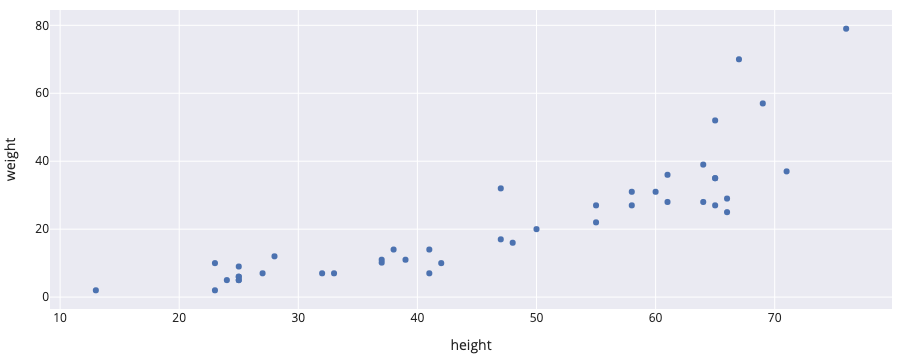

In [52]:
px.scatter(dogs, x='height', y='weight',
           width=350, height=250)

When it looks like two variables have a non-linear relationship, it's useful
to try applying a log scale the x-axis, y-axis, or both.
We look for a linear relationship in the scatter plot with transformed axes.
For instance, in the plot below, we applied a log scale to both x- and y-axes.

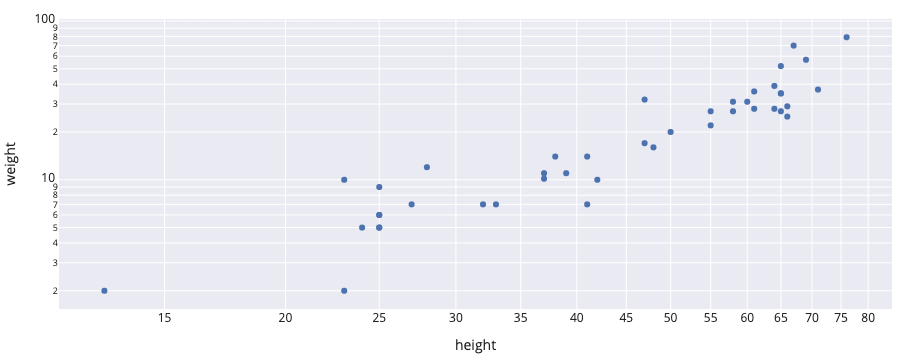

In [53]:
px.scatter(dogs, x='height', y='weight',
           log_x=True, log_y=True,
           width=350, height=350)

This plot shows a roughly linear relationship when both axes are on a log scale.
In this case, we can say that there's a polynomial relationship between dog height and weight.
This makes sense intuitively---if a dog is taller, it's probably proportionally both longer
and wider so we might expect that the weight of a dog has a cubic relationship with its height.


In general, when we see a linear relationship after transforming one or both axes, we can use
{numref}`Table %s <tab:transform-rels>` to reveal what relationship the original variables have.
We make these transformations because it is easier for us to see whether points fall along a line or not than to see if they follow a polynomial rather than an exponetial curve.  
(The derivations of these relationships requires a bit of algebra, which
we leave to the exercises.)

:::{table} Relationships between two variables when transformations are applied. $a$ and $b$ are constants.
:name: tab:transform-rels

| x-axis       | y-axis       | Relationship              |
| ------------ | ------------ | ------------------------- |
| No transform | No transform | Linear: $ y = ax + b $    |
| Log-scale    | No transform | Log: $ y = a \log x + b $ |
| No transform | Log-scale    | Exponential: $ y = ba^x $ |
| Log-scale    | Log-scale    | Polynomial: $ y = bx^a $  |

:::

As {numref}`Table %s <tab:transform-rels>` shows, 
the log transform can reveal several common types of relationships.
Because of this, the log transform is considered the jackknife of 
transformations.
As another, albeit
artificial, example, the leftmost plot in
{numref}`Figure %s <example-transforms>`
reveals a curvilinear
relationship between x and y. The middle plot show a different curvilinear
relationship between log(y) and x; this plot also appears nonlinear. A
further log transformation, at the far right in the figure, displays a plot of
log(y) against log(x). This plot confirms that the data have a log-log (or polynomial)
relationship because the transformed points fall along a line.

```{figure} figures/example-transforms.png
---
name: example-transforms
---

These scatter plots show how log transforms can "straighten" a curvilinear
relationship between two variables.
```

Adjusting scale is an important practice in data visualization.
In this section, we adjusted the limits of x- and y-axes to fill the data 
region to make it easier to see shape and patterns in the data.
We also demonstrated how dot plots and bar charts of proportions and counts
need to start at 0 in order to make accurate comparisons.
We also saw how applying a log transformation to highly skewed data can help
reveal features in the shape of a distribution and in the form of a relationship.
Another way to adjust scale is with the aspect ratio. Changing the length and width of a scatter plot so that the data bank to 45 degrees helps us see curvature in a relationship. And when we straighten a curve by using a log transformation of one or both axes, we can better assess the form of the original nonlinear relationship. 
 
In the next section, we'll look at principles of smoothing which we use 
when we need to visualize lots of data at once.